## Distributed Cryptocurrency System
- Prianka Bhattacharjee
- Mohsen Ghasemizade

In [1]:
# Imports and definitions
import numpy as np
from collections import defaultdict
from collections import namedtuple
import urllib.request
import hashlib
from nacl.signing import SigningKey
import random

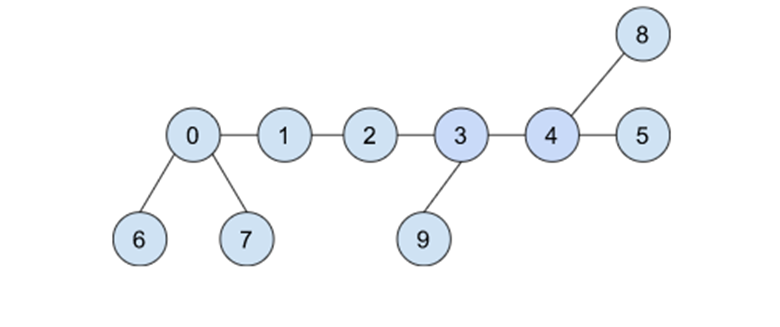

In [2]:
# P2P Network
number_of_participants = 10
adjacency_list = []
adjacency_list.append([1, 6, 7])
adjacency_list.append([0, 2])
adjacency_list.append([1, 3])
adjacency_list.append([2, 4, 9])
adjacency_list.append([3, 5, 8])
adjacency_list.append([4])
adjacency_list.append([0])
adjacency_list.append([0])
adjacency_list.append([4])
adjacency_list.append([3])

In [3]:
class Participant:
    def __init__(self, key, public_key, neighbors, blockchain):
        self.key = key
        self.public_key = public_key
        self.neighbors = neighbors
        self.blockchain = blockchain

participants = []
for i in range(number_of_participants):
    key = SigningKey.generate()
    participants.append(Participant(key, key.verify_key, adjacency_list[i], None))

In [4]:
HashPointer = namedtuple('HashPointer', ['hash', 'pointer'])
Transaction = namedtuple('Transaction', ['inputs', 'outputs'])

Input = namedtuple('Input', ['previous_tx', 'index', 'public_key'])
SignedInput = namedtuple('SignedInput', ['input', 'signed_input'])

Output = namedtuple('Output', ['public_key_hash', 'value'])

DIFFICULTY = int(2**(32 * 8)/10000)

class Block:
    def __init__(self, transactions, prev, nonce, pubkey_hash):
        self.transactions = transactions
        self.prev = prev
        self.nonce = nonce
        self.pubkey_hash = pubkey_hash
    
    def __repr__(self):
        return f'\nBlock(\n transaction: {self.transactions},\n nonce: {self.nonce},\n prev: {self.prev})'

def bytes_value(v):
    return bytes(str(v), encoding='utf-8')

def hash_value(v):
    return hashlib.sha256(bytes_value(v)).hexdigest()


In [5]:
def add_block(transactions, blockchain, nonce, pubkey_hash):
    prev_hash = hash_value(blockchain)
    prev = HashPointer(prev_hash, blockchain)
    new_block = Block(transactions, prev, nonce, pubkey_hash)
    
    return new_block, hash_value(new_block)

def mine_for_block(transactions, pubkey_hash, blockchain):
    nonce = 0
    while True:
        nonce = nonce + 1
        new_blockchain, final_hash = add_block(transactions, blockchain, nonce, pubkey_hash)
        if int(final_hash, 16) <= DIFFICULTY:
            print('Found a block! Final nonce:', nonce)
            return new_blockchain, final_hash
                        
def check_blockchain(blockchain, expected_hash):
    current_block = blockchain
    transactions_to_check = {}

    while current_block != None:
#         print('Checking block:.---------------------------- ', current_block)
        recomputed_hash = hashlib.sha256(bytes(str(current_block), encoding='utf-8')).hexdigest()

        # check that hash is correct
        assert expected_hash == recomputed_hash
        # check that hash is less than difficulty
        assert int(recomputed_hash, 16) <= DIFFICULTY
        
        miner_pubkey_hash = current_block.pubkey_hash
        
        if(current_block.transactions):
            # check the transactions
            for tx in current_block.transactions:
                #print(list(transactions_to_check.keys()))

                if len(tx.inputs) == 1 and tx.inputs[0].input.previous_tx == 'COINBASE':
                    #print('coinbase')
                    inp = tx.inputs[0].input
                    sig = tx.inputs[0].signed_input
                    # miner's public key should be input key
                    assert hash_value(inp.public_key) == miner_pubkey_hash
                    # miner should sign transaction
                    assert inp.public_key.verify(sig)

                    # validate transactions to check
                    hash_tx = hash_value(tx)
                    #print('coinbase hash', hash_tx)
                    if (hash_tx, 0) in transactions_to_check:
                        signed_inp = transactions_to_check[(hash_tx, 0)]
                        inp = signed_inp.input

                        #print('foundit')

                else:
                    #print('non coinbase')
                    hash_tx = hash_value(tx)

                    for i, signed_inp in enumerate(tx.inputs):
                        inp = signed_inp.input
                        transactions_to_check[(inp.previous_tx, i)] = signed_inp
                    pass

                    #print('found coinbase')
                #print(tx)

        prev_pointer = current_block.prev
        current_block = prev_pointer.pointer
        expected_hash = prev_pointer.hash
    return True

def broadcast_block(participant):
    for i in range(len(participant.neighbors)):
        neighbor = participants[participant.neighbors[i]]
        if(check_blockchain(participant.blockchain[0], participant.blockchain[1])):
            if(neighbor.blockchain[1] != participant.blockchain[1]):
                new_blockchain, final_hash = add_block(participant.blockchain[0].transactions, neighbor.blockchain[0], None, neighbor.public_key)
                neighbor.blockchain = (new_blockchain, final_hash)

In [6]:
for i in range(number_of_participants):
    i1 = Input('COINBASE', 0, participants[i].public_key)
    i1_signed = SignedInput(i1, participants[i].key.sign(bytes_value(i1)))
    o1 = Output(hash_value(participants[i].public_key), 10.0)
    tx1 = Transaction([i1_signed], [o1])
    
    new_blockchain, final_hash = mine_for_block([tx1], hash_value(participants[i].public_key), None)
    participants[i].blockchain = (new_blockchain, final_hash)


Found a block! Final nonce: 17860
Found a block! Final nonce: 37147
Found a block! Final nonce: 19216
Found a block! Final nonce: 24164
Found a block! Final nonce: 6708
Found a block! Final nonce: 18375
Found a block! Final nonce: 12045
Found a block! Final nonce: 32903
Found a block! Final nonce: 17180
Found a block! Final nonce: 13694


In [7]:
# Before Transaction
print('Participant 0\'s blockchain--------------')
print(participants[0].blockchain)

Participant 0's blockchain--------------
(
Block(
 transaction: [Transaction(inputs=[SignedInput(input=Input(previous_tx='COINBASE', index=0, public_key=<nacl.signing.VerifyKey object at 0x7fd8e8dd8820>), signed_input=b'\xc4\xa0!\xbd\xfdY\x86B\x0f\xc1\xb4q\xe8s2#\xe8w\xd3\xc9\xd6\xc1\x0b"\xcc`\xa1\xde\xe9U\x9a\x8f\xeb\xe2\x85^C7\xa39`\xbe\n\x9d\xccI,:\x89{\x95\x9a6\xe9\xba\x93\x084e?\xd0\xb7\x01\tInput(previous_tx=\'COINBASE\', index=0, public_key=<nacl.signing.VerifyKey object at 0x7fd8e8dd8820>)')], outputs=[Output(public_key_hash='2ab6dc7c83f5f06f3e5317357f3fc722449144d42e19f704dd4ef3e5c4583eff', value=10.0)])],
 nonce: 17860,
 prev: HashPointer(hash='dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758e8014a24c7fa039e91', pointer=None)), '0005cff07320fc03ad81dd76b73f09df7fc1d46aa37188be7b6f0f09937d762e')


In [8]:
# Node 0 pays some to node 2
i2 = Input(hash_value(tx1), 0, participants[0].public_key)
i2_signed = SignedInput(i2, participants[0].key.sign(bytes_value(i2)))
o2 = Output(hash_value(participants[0].public_key), 9.0)
o3 = Output(hash_value(participants[2].public_key), 1.0)
tx2 = Transaction([i2_signed], [o2, o3])

# Mine the block
new_blockchain, final_hash = mine_for_block([tx2], hash_value(participants[0].public_key), participants[0].blockchain[0])
participants[0].blockchain = (new_blockchain, final_hash)
broadcast_block(participants[0])

Found a block! Final nonce: 29326


In [9]:
# After transaction
print('Participant 0\'s blockchain--------------------------------------------------------------------------')
print(participants[0].blockchain)

print('Participant 1\'s blockchain--------------------------------------------------------------------------')
print(participants[1].blockchain)

Participant 0's blockchain--------------------------------------------------------------------------
(
Block(
 transaction: [Transaction(inputs=[SignedInput(input=Input(previous_tx='4233af02c600f10edd7888d7653edbec9afa1b927eb2061f331652b9de6b2347', index=0, public_key=<nacl.signing.VerifyKey object at 0x7fd8e8dd8820>), signed_input=b":\x94\xe2}\xfd\xa0\xba\x1c\x1d\x0ezn\xc4\x13E\xa2\xe0\xc7j\x8d\xb8\xfbr\xf5G\xe9\xfdD\x92\x8e)\x0cS\xbf\x86\xceH?\xf5\xae\x06\xe4\\\xd1\xb1\xf1H\x05x$\x7f\xa1\xcag\xc50\xd6\x1e\xa2\x12\xa0\xb7\x0e\x02Input(previous_tx='4233af02c600f10edd7888d7653edbec9afa1b927eb2061f331652b9de6b2347', index=0, public_key=<nacl.signing.VerifyKey object at 0x7fd8e8dd8820>)")], outputs=[Output(public_key_hash='2ab6dc7c83f5f06f3e5317357f3fc722449144d42e19f704dd4ef3e5c4583eff', value=9.0), Output(public_key_hash='aa7e87d2c4beca8b449c5f640256fc396657deac6769bc261155104fd1394e92', value=1.0)])],
 nonce: 29326,
 prev: HashPointer(hash='0005cff07320fc03ad81dd76b73f09df7fc1d46aa3718

In [10]:
broadcast_block(participants[2])
broadcast_block(participants[4])
broadcast_block(participants[9])

In [11]:
for i in range(number_of_participants):
    label = "Participant " + str(i) + " blockchain--------------------------------------------------------------------------"
    print(label)
    print(participants[i].blockchain)

Participant 0 blockchain--------------------------------------------------------------------------
(
Block(
 transaction: [Transaction(inputs=[SignedInput(input=Input(previous_tx='4233af02c600f10edd7888d7653edbec9afa1b927eb2061f331652b9de6b2347', index=0, public_key=<nacl.signing.VerifyKey object at 0x7fd8e8dd8820>), signed_input=b":\x94\xe2}\xfd\xa0\xba\x1c\x1d\x0ezn\xc4\x13E\xa2\xe0\xc7j\x8d\xb8\xfbr\xf5G\xe9\xfdD\x92\x8e)\x0cS\xbf\x86\xceH?\xf5\xae\x06\xe4\\\xd1\xb1\xf1H\x05x$\x7f\xa1\xcag\xc50\xd6\x1e\xa2\x12\xa0\xb7\x0e\x02Input(previous_tx='4233af02c600f10edd7888d7653edbec9afa1b927eb2061f331652b9de6b2347', index=0, public_key=<nacl.signing.VerifyKey object at 0x7fd8e8dd8820>)")], outputs=[Output(public_key_hash='2ab6dc7c83f5f06f3e5317357f3fc722449144d42e19f704dd4ef3e5c4583eff', value=9.0), Output(public_key_hash='aa7e87d2c4beca8b449c5f640256fc396657deac6769bc261155104fd1394e92', value=1.0)])],
 nonce: 29326,
 prev: HashPointer(hash='0005cff07320fc03ad81dd76b73f09df7fc1d46aa37188b